In [2]:
from IPython.core.display import HTML
def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()


# Introduction to PyMC
______

PyMC is a python module that implements Bayesian statistical models and
fitting algorithms, including Markov chain Monte Carlo. Its flexibility
and extensibility make it applicable to a large suite of problems. Along
with core sampling functionality, PyMC includes methods for summarizing
output, plotting, goodness-of-fit and convergence diagnostics.

PyMC provides functionalities to make Bayesian analysis as painless as
possible. Here is a short list of some of its features:

-   Fits Bayesian statistical models with Markov chain Monte Carlo and
    other algorithms.
-   Includes a large suite of well-documented statistical distributions.
-   Uses NumPy for numerics wherever possible.
-   Includes a module for modeling Gaussian processes.
-   Sampling loops can be paused and tuned manually, or saved and
    restarted later.
-   Creates summaries including tables and plots.
-   Traces can be saved to the disk as plain text, Python pickles,
    SQLite or MySQL database, or hdf5 archives.
-   Several convergence diagnostics are available.
-   Extensible: easily incorporates custom step methods and unusual
    probability distributions.
-   MCMC loops can be embedded in larger programs, and results can be
    analyzed with the full power of Python.

In [3]:
%matplotlib inline
from pymc import Normal, Lambda, observed, MCMC, Matplot, Uniform
from pymc.examples import melanoma_data as data
import numpy as np

# Convert censoring indicators to indicators for failure event
failure = (data.censored==0).astype(int)

# Intercept for survival rate
beta0 = Normal('beta0', mu=0.0, tau=0.0001, value=0.0)
# beta0 = Uniform('beta0', -10, 10, value=0)
# Treatment effect
beta1 = Normal('beta1', mu=0.0, tau=0.0001, value=0.0)

# Survival rates
lam = Lambda('lam', lambda b0=beta0, b1=beta1, tr=data.treat: np.exp(b0 + b1*tr))

@observed
def survival(value=data.t, lam=lam, f=failure):
    """Exponential survival likelihood, accounting for censoring"""
    return sum(f*np.log(lam) - lam*value)

This example will generate 10000 posterior samples, thinned by a factor
of 2, with the first half discarded as burn-in. The sample is stored in
a Python serialization (pickle) database.

In [4]:
M = MCMC([beta0, beta1, lam, survival])
M.sample(iter=10000, burn=5000)

 [-----------------100%-----------------] 10000 of 10000 complete in 2.2 sec

Plotting beta0


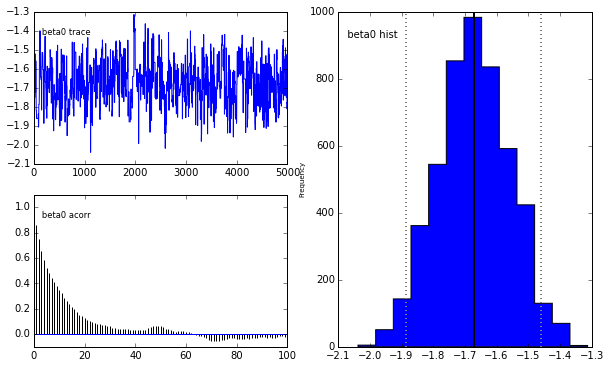

In [5]:
Matplot.plot(beta0)

Plotting beta0


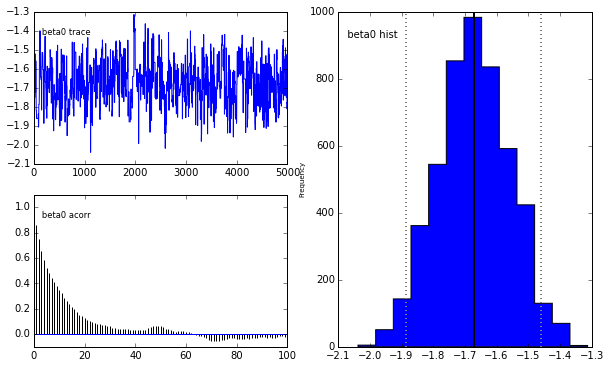

In [6]:
Matplot.plot(beta0)

## Example: Coal mining disasters

Recall the earlier example of estimating a changepoint in the time series of UK coal mining disasters.

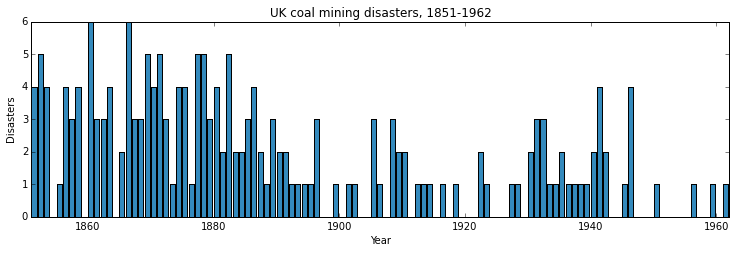

In [7]:
from pymc.examples.disaster_model import disasters_array
import matplotlib.pyplot as plt

n_count_data = len(disasters_array)

plt.figure(figsize=(12.5, 3.5))
plt.bar(np.arange(1851, 1962), disasters_array, color="#348ABD")
plt.xlabel("Year")
plt.ylabel("Disasters")
plt.title("UK coal mining disasters, 1851-1962")
plt.xlim(1851, 1962);

We represent our conceptual model formally as a statistical model:

$$\begin{array}{ccc}  
(y_t | \tau, \lambda_1, \lambda_2) \sim\text{Poisson}\left(r_t\right), & r_t=\left\{
\begin{array}{lll}             
\lambda_1 &\text{if}& t< \tau\\ 
\lambda_2 &\text{if}& t\ge \tau             
\end{array}\right.,&t\in[t_l,t_h]\\         
\tau \sim \text{DiscreteUniform}(t_l, t_h)\\         
\lambda_1\sim \text{Exponential}(a)\\         
\lambda_2\sim \text{Exponential}(b)     
\end{array}$$

Because we have defined $y$ by its dependence on $\tau$, $\lambda_1$ and $\lambda_2$, the
latter three are known as the *parents* of $y$ and $D$ is called their
*child*. Similarly, the parents of $\tau$ are $t_l$ and $t_h$, and $\tau$ is
the child of $t_l$ and $t_h$.

## PyMC Variables

At the model-specification stage (before the data are observed), $y$,
$\tau$, $\lambda_1$, and $\lambda_2$ are all random variables. Bayesian "random"
variables have not necessarily arisen from a physical random process.
The Bayesian interpretation of probability is *epistemic*, meaning
random variable $x$'s probability distribution $p(x)$ represents our
knowledge and uncertainty about $x$'s value. Candidate
values of $x$ for which $p(x)$ is high are relatively more probable,
given what we know. Random variables are represented in PyMC by the
classes `Stochastic` and `Deterministic`.

The only `Deterministic` in the model is $r$. If we knew the values of
$r$'s parents, we could compute the value of $r$
exactly. A `Deterministic` like $r$ is defined by a mathematical
function that returns its value given values for its parents.
`Deterministic` variables are sometimes called the *systemic* part of
the model. The nomenclature is a bit confusing, because these objects
usually represent random variables; since the parents of $r$ are random,
$r$ is random also.

On the other hand, even if the values of the parents of variables
`switchpoint`, \`disasters\` (before observing the data), `early_mean`
or `late_mean` were known, we would still be uncertain of their values.
These variables are characterized by probability distributions that
express how plausible their candidate values are, given values for their
parents. The `Stochastic` class represents these variables.

First, we represent the unknown switchpoint as a discrete uniform random variable:

In [8]:
from pymc import DiscreteUniform, Exponential, Poisson, deterministic

switchpoint = DiscreteUniform('switchpoint', lower=0, upper=110, value=50)

`DiscreteUniform` is a subclass of `Stochastic` that represents
uniformly-distributed discrete variables. Use of this distribution
suggests that we have no preference *a priori* regarding the location of
the switchpoint; all values are equally likely. 

Now we create the
exponentially-distributed variables `early_mean` and `late_mean` for the
early and late Poisson rates, respectively:

In [9]:
early_mean = Exponential('early_mean', beta=1., value=0.1)
late_mean = Exponential('late_mean', beta=1., value=1)

Next, we define the variable `rate`, which selects the early rate
`early_mean` for times before `switchpoint` and the late rate
`late_mean` for times after `switchpoint`. We create `rate` using the
`deterministic` decorator, which converts the ordinary Python function
`rate` into a `Deterministic` object.

In [10]:
@deterministic(plot=False)
def rate(s=switchpoint, e=early_mean, l=late_mean):
    ''' Concatenate Poisson means '''
    out = np.empty(len(disasters_array))
    out[:s] = e
    out[s:] = l
    return out

The last step is to define the number of disasters `disasters`. This is
a stochastic variable but unlike `switchpoint`, `early_mean` and
`late_mean` we have observed its value. To express this, we set the
argument `observed` to `True` (it is set to `False` by default). This
tells PyMC that this object's value should not be changed:

In [11]:
disasters = Poisson('disasters', mu=rate, value=disasters_array, 
                    observed=True)

In [12]:
disasters.logp

-491.65777949611623

### Why are data and unknown variables represented by the same object?

Since its represented by a `Stochastic` object, `disasters` is defined
by its dependence on its parent `rate` even though its value is fixed.
This isn't just a quirk of PyMC's syntax; Bayesian hierarchical notation
itself makes no distinction between random variables and data. The
reason is simple: to use Bayes' theorem to compute the posterior, we require the
likelihood. Even though `disasters`'s value is known
and fixed, we need to formally assign it a probability distribution as
if it were a random variable. Remember, the likelihood and the
probability function are essentially the same, except that the former is
regarded as a function of the parameters and the latter as a function of
the data.

This point can be counterintuitive at first, as many peoples' instinct
is to regard data as fixed a priori and unknown variables as dependent
on the data. One way to understand this is to think of statistical
modelsas predictive models for data, or as
models of the processes that gave rise to data. Before observing the
value of `disasters`, we could have sampled from its prior predictive
distribution $p(y)$ (*i.e.* the marginal distribution of the data) as
follows:

> -   Sample `early_mean`, `switchpoint` and `late_mean` from their
>     priors.
> -   Sample `disasters` conditional on these values.

Even after we observe the value of `disasters`, we need to use this
process model to make inferences about `early_mean` , `switchpoint` and
`late_mean` because its the only information we have about how the
variables are related.

## Parents and children

We have above created a PyMC probability model, which is simply a linked
collection of variables. To see the nature of the links, iexamine `switchpoint`'s `parents` attribute:

In [13]:
switchpoint.parents

{'lower': 0, 'upper': 110}

The `parents` dictionary shows us the distributional parameters of
`switchpoint`, which are constants. Now let's examine \`disasters\`'s
parents:

In [14]:
disasters.parents

{'mu': <pymc.PyMCObjects.Deterministic 'rate' at 0x109f3b358>}

In [15]:
rate.parents

{'e': <pymc.distributions.new_dist_class.<locals>.new_class 'early_mean' at 0x10ae32ac8>,
 'l': <pymc.distributions.new_dist_class.<locals>.new_class 'late_mean' at 0x10ae782b0>,
 's': <pymc.distributions.new_dist_class.<locals>.new_class 'switchpoint' at 0x109f10978>}

We are using `rate` as a distributional parameter of `disasters`
(*i.e.* `rate` is `disasters`'s parent). `disasters` internally
labels `rate` as `mu`, meaning `rate` plays the role of the rate
parameter in `disasters`'s Poisson distribution. Now examine `rate`'s
`children` attribute:

In [16]:
rate.children

{<pymc.distributions.new_dist_class.<locals>.new_class 'disasters' at 0x10ae25f28>}

Because `disasters` considers `rate` its parent, `rate` considers
`disasters` its child. Unlike `parents`, `children` is a set (an
unordered collection of objects); variables do not associate their
children with any particular distributional role. Try examining the
`parents` and `children` attributes of the other parameters in the
model.

The following **directed acyclic graph** is a visualization of the
parent-child relationships in the model. Unobserved stochastic variables
`switchpoint`, `early_mean` and `late_mean` are open ellipses, observed
stochastic variable `disasters` is a filled ellipse and deterministic
variable `rate` is a triangle. Arrows point from parent to child and
display the label that the child assigns to the parent. 

![Directed acyclic graph of disaster model](images/dag.png)

As the examples above have shown, PyMC objects need to have a name
assigned, such as `switchpoint`, `early_mean` or `late_mean`. These
names are used for storage and post-processing:

-   as keys in on-disk databases,
-   as node labels in model graphs,
-   as axis labels in plots of traces,
-   as table labels in summary statistics.

A model instantiated with variables having identical names raises an
error to avoid name conflicts in the database storing the traces. In
general however, PyMC uses references to the objects themselves, not
their names, to identify variables.

## Variables' values and log-probabilities

All PyMC variables have an attribute called `value` that stores the
current value of that variable. Try examining `disasters`'s value, and
you'll see the initial value we provided for it:

In [18]:
disasters.value

array([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6, 3, 3, 5, 4, 5, 3, 1,
       4, 4, 1, 5, 5, 3, 4, 2, 5, 2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 1, 3,
       0, 0, 1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1, 0, 1, 0, 1, 0,
       0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2, 3, 3, 1, 1, 2, 1, 1, 1, 1, 2, 4, 2,
       0, 0, 1, 4, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])

If you check the values of `early_mean`, `switchpoint` and `late_mean`,
you'll see random initial values generated by PyMC:

In [19]:
switchpoint.value

array(50)

In [20]:
early_mean.value

array(0.1)

In [21]:
late_mean.value

array(1.0)

Of course, since these are `Stochastic` elements, your values will be
different than these. If you check `rate`'s value, you'll see an array
whose first `switchpoint` elements are `early_mean`,
and whose remaining elements are `late_mean`:

In [22]:
rate.value

array([ 0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,
        0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,
        0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,
        0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,
        0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  1. ,  1. ,  1. ,  1. ,  1. ,
        1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,
        1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,
        1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,
        1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,
        1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,
        1. ])

To compute its value, `rate` calls the function we used to create it,
passing in the values of its parents.

`Stochastic` objects can evaluate their probability mass or density
functions at their current values given the values of their parents. The
logarithm of a stochastic object's probability mass or density can be
accessed via the `logp` attribute. For vector-valued variables like
`disasters`, the `logp` attribute returns the sum of the logarithms of
the joint probability or density of all elements of the value. Try
examining `switchpoint`'s and `disasters`'s log-probabilities and
`early_mean` 's and `late_mean`'s log-densities:

In [23]:
switchpoint.logp

-4.709530201312334

In [24]:
disasters.logp

-491.65777949611623

In [25]:
early_mean.logp

-0.1

In [26]:
late_mean.logp

-1.0

`Stochastic` objects need to call an internal function to compute their
`logp` attributes, as `rate` needed to call an internal function to
compute its value. Just as we created `rate` by decorating a function
that computes its value, it's possible to create custom `Stochastic`
objects by decorating functions that compute their log-probabilities or
densities. Users are thus not
limited to the set of of statistical distributions provided by PyMC.

### Using Variables as parents of other Variables

Let's take a closer look at our definition of `rate`:

    @deterministic(plot=False)
    def rate(s=switchpoint, e=early_mean, l=late_mean):
        ''' Concatenate Poisson means '''
        out = empty(len(disasters_array))
        out[:s] = e
        out[s:] = l
        return out

The arguments `switchpoint`, `early_mean` and `late_mean` are
`Stochastic` objects, not numbers. If that is so, why aren't errors
raised when we attempt to slice array `out` up to a `Stochastic` object?

Whenever a variable is used as a parent for a child variable, PyMC
replaces it with its `value` attribute when the child's value or
log-probability is computed. When `rate`'s value is recomputed,
`s.value` is passed to the function as argument `switchpoint`. To see
the values of the parents of `rate` all together, look at
`rate.parents.value`.

## Fitting the model with MCMC

PyMC provides several objects that fit probability models (linked collections of variables) like ours. The primary such object, `MCMC`, fits models with a Markov chain Monte Carlo algorithm:

In [27]:
from pymc.examples import disaster_model
M = MCMC(disaster_model)

In [28]:
M

In [29]:
M.late_mean

<pymc.distributions.new_dist_class.<locals>.new_class 'late_mean' at 0x10aab84e0>

In this case `M` will expose variables `switchpoint`, `early_mean`, `late_mean` and `disasters` as attributes; that is, `M.switchpoint` will be the same object as `disaster_model.switchpoint`.

To run the sampler, call the MCMC object's `sample()` method with arguments for the number of iterations, burn-in length, and thinning interval (if desired):

In [30]:
M.sample(iter=10000, burn=1000)

 [-----------------100%-----------------] 10000 of 10000 complete in 2.2 sec

### Accessing the samples

The output of the MCMC algorithm is a `trace`, the sequence of
retained samples for each variable in the model. These traces can be
accessed using the `trace(name, chain=-1)` method. For example:


In [31]:
M.trace('early_mean')[1000:]

array([ 3.06651694,  3.06651694,  3.26347107, ...,  2.81488311,
        2.88794624,  2.88794624])

The trace slice `[start:stop:step]` works just like the NumPy array
slice. By default, the returned trace array contains the samples from
the last call to `sample`, that is, `chain=-1`, but the trace from
previous sampling runs can be retrieved by specifying the correspondent
chain index. To return the trace from all chains, simply use
`chain=None`.

### Sampling output

You can examine the marginal posterior of any variable by plotting a
histogram of its trace:

(array([   15.,   145.,   996.,  1672.,  2732.,  1957.,   971.,   332.,
          148.,    32.]),
 array([ 0.5506752 ,  0.63388967,  0.71710414,  0.80031862,  0.88353309,
         0.96674756,  1.04996203,  1.13317651,  1.21639098,  1.29960545,
         1.38281992]),
 <a list of 10 Patch objects>)

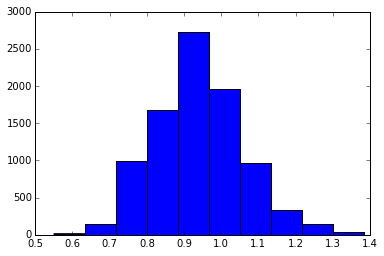

In [32]:
plt.hist(M.trace('late_mean')[:])


PyMC has its own plotting functionality, via the optional `matplotlib`
module as noted in the installation notes. The `Matplot` module includes
a `plot` function that takes the model (or a single parameter) as an
argument:

Plotting switchpoint
Plotting early_mean
Plotting late_mean


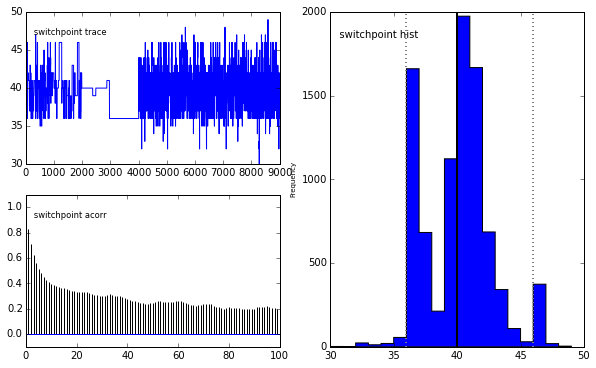

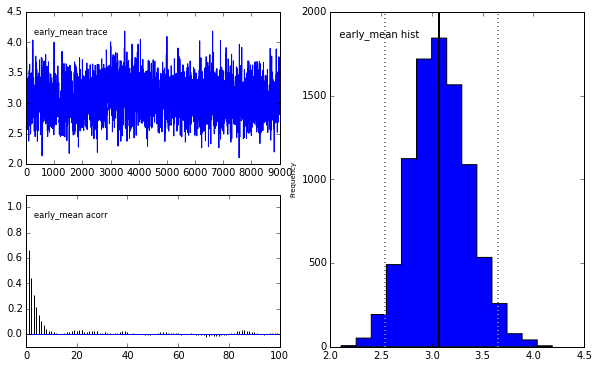

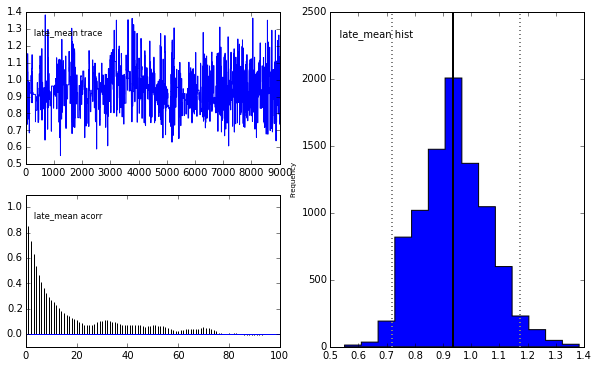

In [33]:
Matplot.plot(M)

The upper left-hand pane of each figure shows the temporal series of the
samples from each parameter, while below is an autocorrelation plot of
the samples. The right-hand pane shows a histogram of the trace. The
trace is useful for evaluating and diagnosing the algorithm's
performance, while the histogram is useful for
visualizing the posterior.

For a non-graphical summary of the posterior, simply call the `stats` method.

In [34]:
M.early_mean.summary()


early_mean:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	3.081            0.286            0.008            [ 2.542  3.657]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	2.544            2.89            3.072          3.265         3.665
	


### Imputation of Missing Data

As with most textbook examples, the models we have examined so far
assume that the associated data are complete. That is, there are no
missing values corresponding to any observations in the dataset.
However, many real-world datasets have missing observations, usually due
to some logistical problem during the data collection process. The
easiest way of dealing with observations that contain missing values is
simply to exclude them from the analysis. However, this results in loss
of information if an excluded observation contains valid values for
other quantities, and can bias results. An alternative is to impute the
missing values, based on information in the rest of the model.

For example, consider a survey dataset for some wildlife species:

    Count   Site   Observer   Temperature
    ------- ------ ---------- -------------
    15      1      1          15
    10      1      2          NA
    6       1      1          11

Each row contains the number of individuals seen during the survey,
along with three covariates: the site on which the survey was conducted,
the observer that collected the data, and the temperature during the
survey. If we are interested in modelling, say, population size as a
function of the count and the associated covariates, it is difficult to
accommodate the second observation because the temperature is missing
(perhaps the thermometer was broken that day). Ignoring this observation
will allow us to fit the model, but it wastes information that is
contained in the other covariates.

In a Bayesian modelling framework, missing data are accommodated simply
by treating them as unknown model parameters. Values for the missing
data $\tilde{y}$ are estimated naturally, using the posterior predictive
distribution:

$$p(\tilde{y}|y) = \int p(\tilde{y}|\theta) f(\theta|y) d\theta$$

This describes additional data $\tilde{y}$, which may either be
considered unobserved data or potential future observations. We can use
the posterior predictive distribution to model the likely values of
missing data.

Consider the coal mining disasters data introduced previously. Assume
that two years of data are missing from the time series; we indicate
this in the data array by the use of an arbitrary placeholder value,
`None`:

In [35]:
x = np.array([ 4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
2, 2, 3, 4, 2, 1, 3, None, 2, 1, 1, 1, 1, 3, 0, 0,
1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
3, 3, 1, None, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])

To estimate these values in PyMC, we generate a *masked array*. These are specialised NumPy arrays that contain a matching True or False value for each element to indicate if that value should be excluded from any computation. Masked arrays can be generated using NumPy's `ma.masked_equal` function:

In [36]:
masked_values = np.ma.masked_values(x, value=None)
masked_values

masked_array(data = [4 5 4 0 1 4 3 4 0 6 3 3 4 0 2 6 3 3 5 4 5 3 1 4 4 1 5 5 3 4 2 5 2 2 3 4 2
 1 3 -- 2 1 1 1 1 3 0 0 1 0 1 1 0 0 3 1 0 3 2 2 0 1 1 1 0 1 0 1 0 0 0 2 1 0
 0 0 1 1 0 2 3 3 1 -- 2 1 1 1 1 2 4 2 0 0 1 4 0 0 0 1 0 0 0 0 0 1 0 0 1 0 1],
             mask = [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False  True
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False],
       fill_value = ?)

This masked array, in turn, can then be passed to one of PyMC's data
stochastic variables, which recognizes the masked array and replaces the
missing values with Stochastic variables of the desired type. For the
coal mining disasters problem, recall that disaster events were modeled
as Poisson variates:

In [37]:
disasters = Poisson('disasters', mu=rate, 
                    value=masked_values, observed=True)

Here `rate` is an array of means for each year of data, allocated
according to the location of the switchpoint. Each element in
`disasters` is a Poisson Stochastic, irrespective of whether the
observation was missing or not. The difference is that actual
observations are data Stochastics (`observed=True`), while the missing
values are non-data Stochastics. The latter are considered unknown,
rather than fixed, and therefore estimated by the MCMC algorithm, just
as unknown model parameters.

The entire model looks very similar to the original model:

In [38]:
def missing_data_model():

    # Switchpoint
    switch = DiscreteUniform('switch', lower=0, upper=110)
    # Early mean
    early_mean = Exponential('early_mean', beta=1)
    # Late mean
    late_mean = Exponential('late_mean', beta=1)
    
    @deterministic(plot=False)
    def rate(s=switch, e=early_mean, l=late_mean):
        """Allocate appropriate mean to time series"""
        out = np.empty(len(disasters_array))
        # Early mean prior to switchpoint
        out[:s] = e
        # Late mean following switchpoint
        out[s:] = l
        return out
    
    masked_values = np.ma.masked_values(x, value=None)
    
    # Pass masked array to data stochastic, and it does the right thing
    disasters = Poisson('disasters', mu=rate, value=masked_values, observed=True)
    
    return locals()

Here, we have used the `masked_array` function, rather than
`masked_equal`, and the value -999 as a placeholder for missing data.
The result is the same.

In [39]:
M_missing = MCMC(missing_data_model())
M_missing.sample(5000)

 [-----------------100%-----------------] 5000 of 5000 complete in 1.5 sec

In [40]:
M_missing.stochastics

{<pymc.distributions.new_dist_class.<locals>.new_class 'disasters' at 0x10c460978>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'late_mean' at 0x10c460d68>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'early_mean' at 0x10c460f98>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'switch' at 0x10c465978>}

Plotting disasters_0
Plotting disasters_1


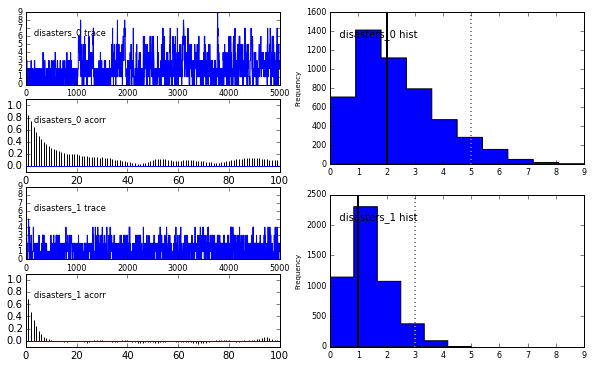

In [41]:
Matplot.plot(M_missing.disasters)

## Fine-tuning the MCMC algorithm

MCMC objects handle individual variables via *step methods*, which
determine how parameters are updated at each step of the MCMC algorithm.
By default, step methods are automatically assigned to variables by
PyMC. To see which step methods $M$ is using, look at its
`step_method_dict` attribute with respect to each parameter:

In [42]:
M.step_method_dict

{<pymc.distributions.new_dist_class.<locals>.new_class 'late_mean' at 0x10aab84e0>: [<pymc.StepMethods.Metropolis at 0x109feab00>],
 <pymc.distributions.new_dist_class.<locals>.new_class 'early_mean' at 0x10aaab630>: [<pymc.StepMethods.Metropolis at 0x109fea160>],
 <pymc.distributions.new_dist_class.<locals>.new_class 'switchpoint' at 0x10aaabf98>: [<pymc.StepMethods.DiscreteMetropolis at 0x109fea550>]}

The value of `step_method_dict` corresponding to a particular variable
is a list of the step methods $M$ is using to handle that variable.

You can force $M$ to use a particular step method by calling
`M.use_step_method` before telling it to sample. The following call will
cause $M$ to handle `late_mean` with a standard `Metropolis` step
method, but with proposal standard deviation equal to $2$:

In [43]:
from pymc import Metropolis
M.use_step_method(Metropolis, disaster_model.late_mean, proposal_sd=2.)

Another step method class, `AdaptiveMetropolis`, is better at handling
highly-correlated variables. If your model mixes poorly, using
`AdaptiveMetropolis` is a sensible first thing to try.